In [1]:
import math
import random
import numpy

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Input

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

lookup tables

In [4]:
# build the vocab of chars and lookup tables
# Q: what will be the vocab for word level language model?

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Dataset creation

Embeddings lookup table

in [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 17k words were embeeded into 30 dims

we have to embed 27 chars into small dims, lets start with 2 dims embedding for now

Hidden & Output Layer

- What would be the input to this layer?

    the embedding have the shape [32, 3, 2] which means that we have 32 inputs and for each input we have three(one for each character) two dims embeddings => 3 * 2 = 6

- What would be the number of neurons, we can try it with different values, lets say 100 for now

Build the Dataset

-  both BOS and EOS are represented using '.'

- context - characters to be considered for the next prediction
    - what would be context for the first letter? just '.', the number of '.' will depend on the length of the context


- make sure to represent the EOS as well

In [6]:
block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])
X_test, Y_test = build_dataset(words[val_window_end:])

shapes:  torch.Size([182580, 3]) torch.Size([182580])
shapes:  torch.Size([22767, 3]) torch.Size([22767])
shapes:  torch.Size([22799, 3]) torch.Size([22799])


training(80%), val(10%), test(10%) splits 
 - training set is used for optimizing the params of the model
 - validation set is used for training the hyperparameters(hidden layer size, embedding size etc)
 - evaluating the performance of the model

### Build the Network

In [7]:
dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
# multiplying by a small value so that the initial values for W2 are not high
# without this the loss would be very high for the first few passes 
# and those passes would be wasted in getting the loss down to a smaller value
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 
b2 = torch.randn(vocab_size,                        generator=g) * 0

params = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

11897


### Train the Network

In [8]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    # minibatch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed the chars into vectors

    # TBD: check on the purpose
    emb_cat = emb.view(emb.shape[0], -1) # vectors concatenation
    h_preact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    # only select the indices in the current mini batch
    loss = F.cross_entropy(logits, Yb)
    # print(f'{loss=}')
    
    # backward pass
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    
    # calculate the gradients of the loss w.r.t params
    loss.backward()

    # if step < 100000:
    #     l_rate = 0.1
    # elif 100000 <= step < 200000:
    #     l_rate = 0.01
    # else:
    #     l_rate = 0.001
    
    l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())

# print(f'{loss=}')

      0/ 200000:3.3148
  10000/ 200000:2.6505
  20000/ 200000:2.4705
  30000/ 200000:2.0266
  40000/ 200000:2.1797
  50000/ 200000:2.4072
  60000/ 200000:2.2316
  70000/ 200000:2.0701
  80000/ 200000:2.0010
  90000/ 200000:2.0439
 100000/ 200000:2.4564
 110000/ 200000:2.2124
 120000/ 200000:2.1843
 130000/ 200000:2.2414
 140000/ 200000:2.1447
 150000/ 200000:2.2837
 160000/ 200000:2.0286
 170000/ 200000:2.0146
 180000/ 200000:2.2178
 190000/ 200000:2.0372


Plot losses per step

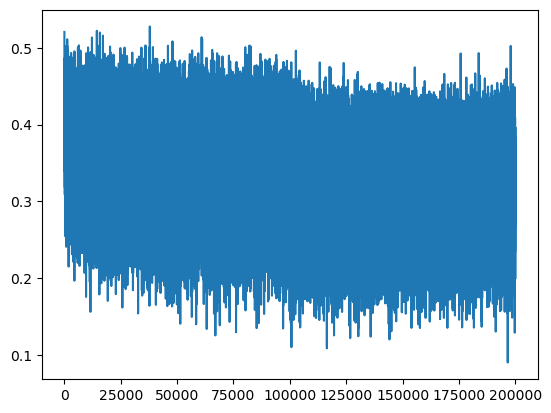

In [9]:
plt.plot(losses_at_idx)

Calculate the training and validation losses

In [10]:
# disable gradient tracking with decorator - 
# this decorator sets the tensors in the function that follows to requires_grad = False

@torch.no_grad() 
def split_losses(split_name):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]

    emb = C[x] # (N, block_size, dim_emb)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * dim_emb)
    h = torch.tanh(emb_cat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split_name, loss.item())

split_losses('train')
split_losses('val')

train 2.069324493408203
val 2.133208751678467


Sampling from the model

In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        # forward pass 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos_lookups[i] for i in out))

carmah.
amillivia.
jmri.
ree.
cassanden.
jazonte.
delynn.
jareei.
ner.
kia.
chaiivia.
leigh.
ham.
join.
quint.
sulenes.
jamilio.
jero.
dearynix.
kaeshiveri.


Note 1: 

try to change the hyperparameters such a hidden layer size by trying different variations, if that doesnt affect the loss value greatly then try to found out why the loss value isnt going down by analysing the layers